In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.fftpack import fft2, fftshift
from scipy.stats import entropy

# Settings
dataset_path = '/content/drive/MyDrive/tumours'
image_size = (128, 128)

# Step 1: Preprocess image
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    equalized = cv2.equalizeHist(image)
    resized = cv2.resize(equalized, image_size)
    normalized = resized / 255.0
    return normalized

# Step 2: Load and preprocess all images
images, labels = [], []
for label in ['Tumor', 'Normal']:
    folder = os.path.join(dataset_path, label)
    for file_name in os.listdir(folder):
        img_path = os.path.join(folder, file_name)
        img = preprocess_image(img_path)
        if img is not None:
            images.append(img)
            labels.append(1 if label == 'Tumor' else 0)

images = np.array(images)
labels = np.array(labels)

# Step 3: FFT Feature Extraction
def extract_fft_features(image):
    fft_result = fftshift(fft2(image))
    mag = np.abs(fft_result)
    energy = np.sum(mag ** 2)
    flat = mag.flatten()
    normalized = flat / np.sum(flat)
    fft_entropy = entropy(normalized)
    dominant_freqs = np.sort(flat)[-5:]
    return [energy, fft_entropy, np.mean(flat), np.std(flat)] + list(dominant_freqs)

features = np.array([extract_fft_features(img) for img in images])

XGBoost Accuracy: 94.86%


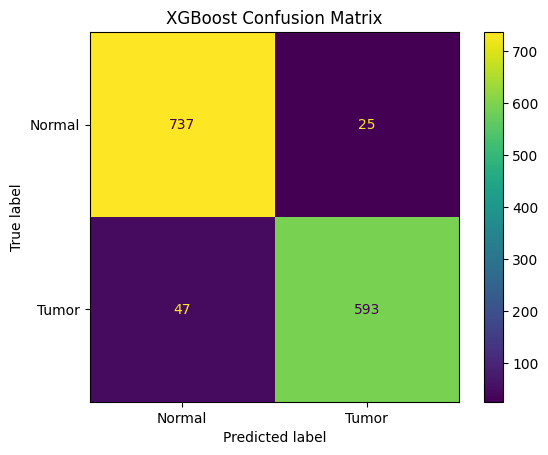

In [10]:
from scipy.fftpack import fft2, fftshift
from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

X = np.array(features)
y = np.array(labels)

# --- Split Dataset ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- Train XGBoost Model ---
model = XGBClassifier(eval_metric='logloss')
model.fit(X_train, y_train)

# --- Predict & Evaluate ---
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuracy: {acc * 100:.2f}%")

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Tumor'])
disp.plot()
plt.title("XGBoost Confusion Matrix")
plt.show()

In [19]:
from sklearn.metrics import accuracy_score, classification_report

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc * 100:.2f}%\n")

# Precision, Recall, F1-score
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Normal", "Tumor"]))


Accuracy: 94.86%

Classification Report:
              precision    recall  f1-score   support

      Normal       0.94      0.97      0.95       762
       Tumor       0.96      0.93      0.94       640

    accuracy                           0.95      1402
   macro avg       0.95      0.95      0.95      1402
weighted avg       0.95      0.95      0.95      1402



In [13]:
import numpy as np

fft_features = np.array(features)

# Show shape and preview
print("FFT Features shape:", fft_features.shape)
print("First 5 feature vectors:")
print(fft_features[:5])

FFT Features shape: (7009, 9)
First 5 feature vectors:
[[5.40283329e+07 8.85603129e+00 1.15149288e+01 5.62586363e+01
  1.79938968e+03 1.79938968e+03 2.39034479e+03 2.39034479e+03
  5.04905882e+03]
 [7.29414080e+07 9.08177513e+00 1.38171183e+01 6.52769291e+01
  1.48466229e+03 1.48466229e+03 2.36614720e+03 2.36614720e+03
  6.97171373e+03]
 [4.82909875e+07 8.97574714e+00 1.47029484e+01 5.22615659e+01
  1.48880097e+03 1.48880097e+03 2.26788752e+03 2.26788752e+03
  4.58163922e+03]
 [8.82143659e+07 8.92859691e+00 1.61607552e+01 7.15751884e+01
  1.23148661e+03 1.23148661e+03 1.56829739e+03 1.56829739e+03
  8.15531373e+03]
 [5.33530186e+07 8.88433829e+00 1.18340143e+01 5.58244206e+01
  1.76938123e+03 1.76938123e+03 2.38533236e+03 2.38533236e+03
  5.00482745e+03]]


Feature importances:
Energy: 0.2196
Entropy: 0.1201
Mean: 0.0993
Std: 0.1065
Freq1: 0.2332
Freq2: 0.0000
Freq3: 0.0866
Freq4: 0.0000
Freq5: 0.1346


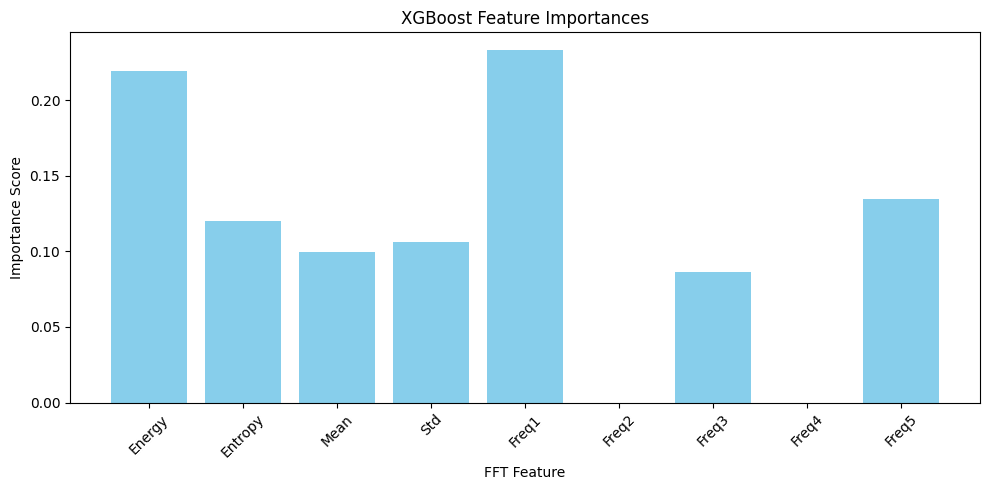

In [21]:
import matplotlib.pyplot as plt
import numpy as np

feature_names = ['Energy', 'Entropy', 'Mean', 'Std', 'Freq1', 'Freq2', 'Freq3', 'Freq4', 'Freq5']
importances = model.feature_importances_

# Print for sanity check
print("Feature importances:")
for name, score in zip(feature_names, importances):
    print(f"{name}: {score:.4f}")

# Plot
plt.figure(figsize=(10, 5))
plt.bar(feature_names, importances, color='skyblue')
plt.xlabel("FFT Feature")
plt.ylabel("Importance Score")
plt.title("XGBoost Feature Importances")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Hybrid Model Accuracy: 93.08%


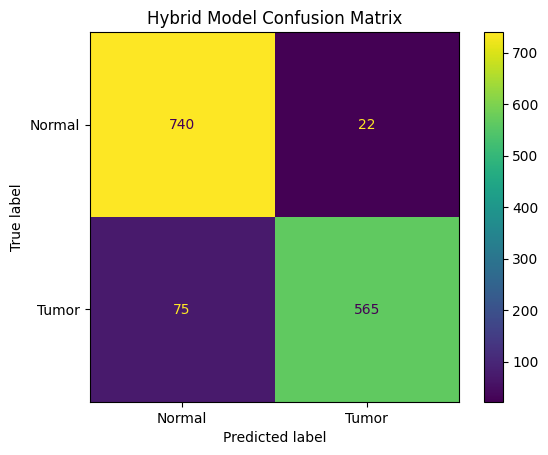

In [25]:
# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

# --- Hybrid Voting Model ---
hybrid = VotingClassifier(estimators=[
    ('svm', SVC(probability=True)),
    ('rf', RandomForestClassifier()),
    ('gb', GradientBoostingClassifier())
], voting='soft')

hybrid.fit(X_train, y_train)
y_pred = hybrid.predict(X_test)

# --- Evaluation ---
acc = accuracy_score(y_test, y_pred)
print(f"Hybrid Model Accuracy: {acc * 100:.2f}%")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Tumor'])
disp.plot()
plt.title("Hybrid Model Confusion Matrix")
plt.show()

In [26]:
from sklearn.metrics import accuracy_score, classification_report

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc * 100:.2f}%\n")

# Precision, Recall, F1-score
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Normal", "Tumor"]))

Accuracy: 93.08%

Classification Report:
              precision    recall  f1-score   support

      Normal       0.91      0.97      0.94       762
       Tumor       0.96      0.88      0.92       640

    accuracy                           0.93      1402
   macro avg       0.94      0.93      0.93      1402
weighted avg       0.93      0.93      0.93      1402



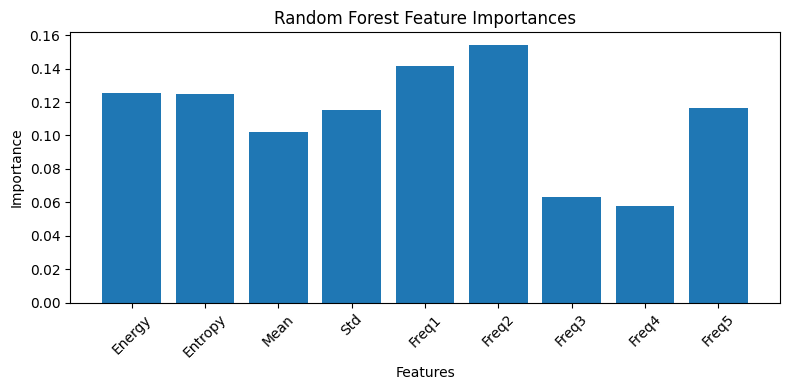

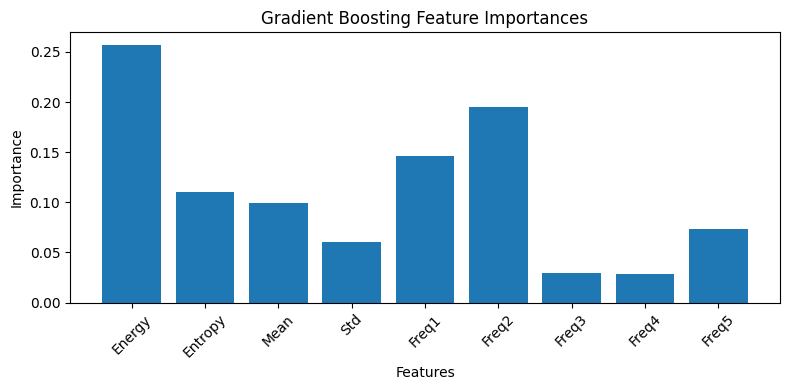

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature importances from individual models
rf_importances = hybrid.named_estimators_['rf'].feature_importances_
gb_importances = hybrid.named_estimators_['gb'].feature_importances_

# Feature names
feature_names = ['Energy', 'Entropy', 'Mean', 'Std', 'Freq1', 'Freq2', 'Freq3', 'Freq4', 'Freq5']

# Plot for RandomForest
plt.figure(figsize=(8, 4))
plt.bar(range(len(rf_importances)), rf_importances)
plt.xticks(range(len(rf_importances)), feature_names, rotation=45)
plt.title("Random Forest Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# Plot for GradientBoosting
plt.figure(figsize=(8, 4))
plt.bar(range(len(gb_importances)), gb_importances)
plt.xticks(range(len(gb_importances)), feature_names, rotation=45)
plt.title("Gradient Boosting Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [34]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Train the LightGBM model
model = LGBMClassifier(verbose=-1)

model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc * 100:.2f}%\n")

# Precision, Recall, F1-score
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Normal", "Tumor"]))


Accuracy: 94.37%

Classification Report:
              precision    recall  f1-score   support

      Normal       0.93      0.96      0.95       762
       Tumor       0.96      0.92      0.94       640

    accuracy                           0.94      1402
   macro avg       0.95      0.94      0.94      1402
weighted avg       0.94      0.94      0.94      1402



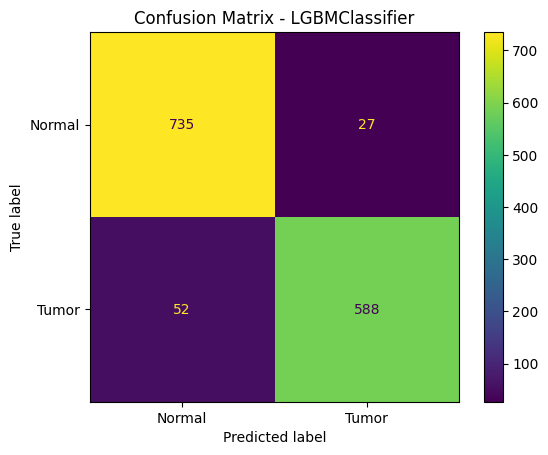

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Tumor"])
disp.plot( values_format='d')
plt.title("Confusion Matrix - LGBMClassifier")
plt.show()


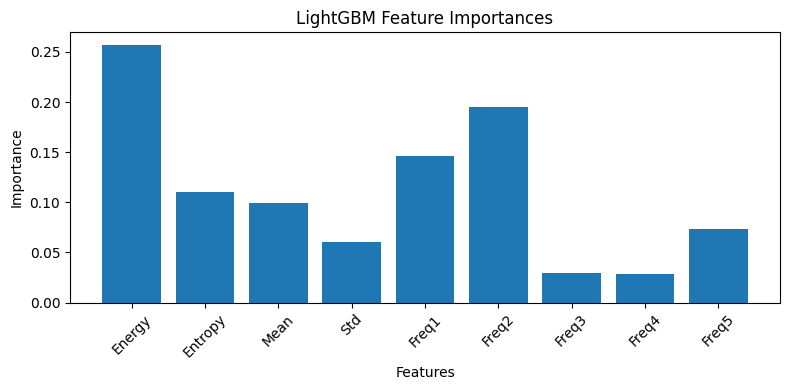

In [35]:
import matplotlib.pyplot as plt

# Extract feature importances from the LightGBM classifier in the hybrid model
lgb_importances = hybrid.named_estimators_['gb'].feature_importances_

# Feature names (same as before)
feature_names = ['Energy', 'Entropy', 'Mean', 'Std', 'Freq1', 'Freq2', 'Freq3', 'Freq4', 'Freq5']

# Plot for LightGBM
plt.figure(figsize=(8, 4))
plt.bar(range(len(lgb_importances)), lgb_importances)
plt.xticks(range(len(lgb_importances)), feature_names, rotation=45)
plt.title("LightGBM Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()
